In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

## Import Data

In [2]:
earnings_path = 'data\\processed\\df_quarter_eps_average_08_09.csv'
training_price_path = 'data\\processed\\df_price07_18.csv'
dividend_path = 'data\\processed\\df_monthly_div_07_18.csv'
key_path = 'data\\external\\quarterly_key_sp_500.csv'
testing_price_path = 'data\\processed\\df_price19.csv'
testing_dividend_path = 'data\\processed\\df_quarter_div_19.csv'
# main metric import

df = pd.read_csv(earnings_path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

# import daily price 07-18

df_price = pd.read_csv(training_price_path)
df_price.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price['Stock'].str.split('_', expand=True)
df_price['symbol'] = new[0]
df_price.index = df_price['symbol']
df_price.drop(['Stock', 'symbol'], axis=1, inplace = True)

# import dividend matrix

df_div = pd.read_csv(dividend_path)
df_div.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div.index = df_div['Stock']
df_div.drop('Stock', axis=1, inplace = True)

# import 2019 price

df_price_19 = pd.read_csv(testing_price_path)
df_price_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price_19['Stock'].str.split('_', expand=True)
df_price_19['symbol'] = new[0]
df_price_19.index = df_price_19['symbol']
df_price_19.drop(['Stock', 'symbol'], axis=1, inplace = True)
df_price_19.sort_index(inplace=True)

# import 2019 dividends
df_div_19 = pd.read_csv(testing_dividend_path)
df_div_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div_19.index = df_div_19['Stock']
df_div_19.drop('Stock', axis=1, inplace = True)
#df_key = pd.read_csv(key_path)
#df_key.index = df_key['symbol']
#df_key.drop(['symbol', 'Unnamed: 2'], axis=1, inplace=True)

## Limit to only SP500 Stocks that traded daily

#### Quarterly data has stocks outside of SP500, have to consider whether its worth it to keep or not

In [3]:
# define indices

idx = df.index
idx_price = df_price.index
idx_div = df_div.index

# drop stocks from metric dataframe

idx_diff1 = idx.difference(idx_price)
df.drop(idx_diff1, inplace=True)
print('df shape: {}'.format(df.shape))

# drop stocks from dividend dataframe

idx_diff2 = idx_div.difference(idx_price)
df_div.drop(idx_diff2, inplace=True)
print('df_div shape: {}'.format(df_div.shape))

df shape: (355, 2)
df_div shape: (355, 108)


## Quick Analysis

In [4]:
# separate stocks into candidates and not candidates

#df['hypothesis']=np.where(abs(df['Recession EPS']-df['Average EPS']) < 0.1, 'Candidate', 'Not Candidate')
#colors = {'Candidate':'red', 'Not Candidate':'blue'}
#df['colors']=df['hypothesis'].apply(lambda x: colors[x])

In [5]:
# sort stocks by difference between average and recession eps
# 20% smallest differences become candidate stocks

ratio = int(round(len(df.index)*0.2))
df['difference'] = abs(df['Recession EPS'] - df['Average EPS'])
df.sort_values(by=['difference'], inplace=True)
df['colors'] = ''

df_cand = df.iloc[0:ratio, :]
df_not = df.iloc[ratio:, :]

df_cand['colors'] = 'red'
df_not['colors'] = 'blue'

print('Candidate df shape: {}'.format(df_cand.shape))
print('Not Candidate df shape: {}'.format(df_not.shape))

Candidate df shape: (71, 4)
Not Candidate df shape: (284, 4)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


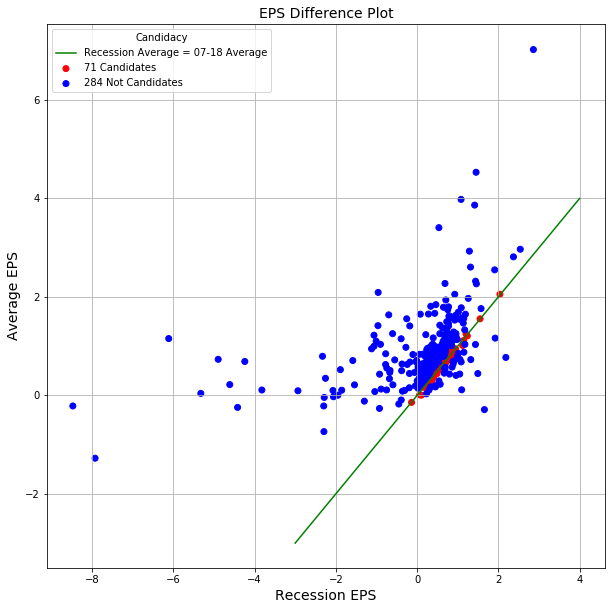

In [6]:
# plot metric decision boundary

sub_title_font =14
legend_font =8
axis_font = 10
x = np.linspace(-3, 4, 100)
y=x

fig, ax = plt.subplots(1, 1, figsize=(10,10))
cand = ax.scatter(df_cand['Recession EPS'], df_cand['Average EPS'], c=df_cand.colors, label='{} Candidates'.format(len(df_cand.index)))
not_cand = ax.scatter(df_not['Recession EPS'], df_not['Average EPS'], c=df_not.colors, label='{} Not Candidates'.format(len(df_not.index)))
line = ax.plot(x, y, c="green", label='Recession Average = 07-18 Average')

plt.xlabel('Recession EPS', fontsize=sub_title_font)
plt.ylabel('Average EPS', fontsize=sub_title_font)
plt.title('EPS Difference Plot', fontsize=sub_title_font)
ax.tick_params(axis="x", labelsize=axis_font)
ax.tick_params(axis="y", labelsize=axis_font)

plt.grid(which='major')
ax.legend(loc = 'upper left', title='Candidacy')
plt.show()

## Build Portfolio

In [7]:
# take top 30 stocks by EPS

df_cand = df_cand.sort_values(by=['Average EPS'], ascending = False)
idx_port = df_cand.head(10).index
print('Portfolio Stocks: {}'.format(idx_port))

# simplify price data to just portfolio stocks

idx_diff3 = idx_price.difference(idx_port)
df_port_price = df_price.drop(idx_diff3)


# simplify dividends data to just portfolio stocks

idx_div2 = df_div.index
idx_diff4 = idx_div2.difference(idx_port)
df_port_div = df_div.drop(idx_diff4)

Portfolio Stocks: Index(['CVX', 'XOM', 'VFC', 'BDX', 'JNJ', 'PG', 'DHR', 'BAX', 'ESS', 'DVA'], dtype='object', name='Stock')


## Calculate Expected Returns

In [8]:
# annual returns - not enough data points
# list start and end dates for years 2010-2018

#start_dates = ['2010-01-04', '2011-01-03', '2012-01-03', '2013-01-02', '2014-01-02', '2015-01-02', '2016-01-04', '2017-01-03', '2018-01-02']
#end_dates = ['2010-12-31', '2011-12-30', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29', '2018-12-31']

In [9]:
# monthly returns

start_dates = ['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01', '2010-05-03', '2010-06-01', 
              '2010-07-01', '2010-08-02', '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', 
              '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-02', '2011-06-01', 
              '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01', 
              '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02', '2012-05-01', '2012-06-01', 
              '2012-07-02', '2012-08-01', '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
              '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03', 
              '2013-07-01', '2013-08-01', '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02', 
              '2014-01-02', '2014-02-03', '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02', 
              '2014-07-01', '2014-08-01', '2014-09-02', '2013-10-01', '2014-11-03', '2014-12-01', 
              '2015-01-02', '2015-02-02', '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
              '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', 
              '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', 
              '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', 
              '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', 
              '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', 
              '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01', '2018-06-01', 
              '2018-07-02', '2018-08-01', '2018-09-04', '2018-10-01', '2018-11-01', '2018-12-03']

end_dates = ['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-28', '2010-06-30', 
            '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', 
            '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', 
            '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', 
            '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', 
            '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', 
            '2013-01-31', '2013-02-28', '2013-03-28', '2013-04-30', '2013-05-31', '2013-06-28', 
            '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', 
            '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', 
            '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', 
            '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', 
            '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31', 
            '2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30', 
            '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30', 
            '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30', 
            '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', 
            '2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29', 
            '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31']

# function to validate lists above

def list_diff(list1, list2):
    out = [item for item in list1 if not item in list2]
    return out

# validate start dates list

print('Missing Start Dates: {}'.format(list_diff(start_dates, list(df_price.columns))))

# validate end dates list

print('Missing End Dates: {}'.format(list_diff(end_dates, list(df_price.columns))))

Missing Start Dates: []
Missing End Dates: []


In [10]:
# initialize risk free rates for each year
# deannualize from the start of each year

rfr10 = (1+0.0013)**(1/3) - 1
rfr11 = (1+0.0005)**(1/3) - 1
rfr12 = (1+0.0011)**(1/3) - 1
rfr13 = (1+0.00075)**(1/3) - 1
rfr14 = (1+0.0004)**(1/3) - 1
rfr15 = (1+0.0004)**(1/3) - 1
rfr16 = (1+0.0035)**(1/3) - 1
rfr17 = (1+0.0099)**(1/3) - 1
rfr18 = (1+0.0185)**(1/3) - 1

In [11]:
# calculate year end returns

temp_returns = pd.DataFrame(index=idx_port)

for start, end in zip(start_dates, end_dates):
    temp_returns[end] = df_port_price[end] - df_port_price[start]

temp_returns.sort_index(inplace=True)


# export temp returns to fix dividend data in excel

#temp_returns.to_csv('data\\processed\\temp_returns_monthly.csv')


# calculate monthly returns

temp_returns = temp_returns + df_port_div


# calculate percentage returns

df_port_returns = pd.DataFrame(index=idx_port)
df_port_returns.sort_index(inplace=True)

for start, end in zip(start_dates, end_dates):
    df_port_returns[end] = temp_returns[end]/df_port_price[start]


# subtract average yearly risk free rate from each year's returns

df_port_returns.iloc[:, 0:12] = df_port_returns.iloc[:, 0:12] - rfr10
df_port_returns.iloc[:, 12:24] = df_port_returns.iloc[:, 12:24] - rfr11
df_port_returns.iloc[:, 24:36] = df_port_returns.iloc[:, 24:36] - rfr12
df_port_returns.iloc[:, 36:48] = df_port_returns.iloc[:, 36:48] - rfr13
df_port_returns.iloc[:, 48:60] = df_port_returns.iloc[:, 48:60] - rfr14
df_port_returns.iloc[:, 60:72] = df_port_returns.iloc[:, 60:72] - rfr15
df_port_returns.iloc[:, 72:84] = df_port_returns.iloc[:, 72:84] - rfr16
df_port_returns.iloc[:, 84:96] = df_port_returns.iloc[:, 84:96] - rfr17
df_port_returns.iloc[:, 96:108] = df_port_returns.iloc[:, 96:108] - rfr18


# calculate expected monthly returns

df_port = pd.DataFrame(index=idx_port)
df_port.sort_index(inplace=True)
df_port['expected returns'] = df_port_returns.mean(axis=1)

## Calculate Variance of each stock

In [12]:
# putting variance values in returns in df

df_port['variance of returns'] = df_port_returns.var(axis=1)
#df_port

## Calculate Covariance Matrix

### Note: Do a Covariance Heatmap 

In [13]:
# covariance matrix

df_cov = df_port_returns.T.cov()


# check if covariance matrix is invertible
# inverse of covariance matrix

df_cov_inv = pd.DataFrame(np.linalg.inv(df_cov.values), df_cov.columns, df_cov.index)
df_cov_inv.dot(df_cov)

#cov_mat = np.cov(df_port_returns)
#cov_inv = np.linalg.inv(cov_mat)
#cov_mat.dot(cov_inv)

Stock,BAX,BDX,CVX,DHR,DVA,ESS,JNJ,PG,VFC,XOM
Stock,,,,,,,,,,
BAX,1.000000e+00,-8.492069e-17,-2.592786e-16,-1.105662e-16,-7.935240e-17,-5.162268e-17,-1.024730e-16,-9.819439e-17,-1.942890e-16,-2.775558e-16
BDX,-1.118251e-17,1.000000e+00,-1.295820e-16,3.257364e-18,-1.071393e-16,4.694723e-17,-8.532071e-17,-1.763098e-16,-2.775558e-17,1.110223e-16
CVX,8.771108e-18,2.825166e-17,1.000000e+00,-1.035126e-17,5.212690e-17,3.179372e-17,1.412121e-16,6.983165e-17,1.110223e-16,2.220446e-16
DHR,4.015601e-17,3.702149e-17,-5.928422e-17,1.000000e+00,8.364250e-17,1.449077e-17,-5.248368e-17,2.570032e-17,5.551115e-17,-5.551115e-17
DVA,7.259875e-17,-4.503064e-17,9.804378e-17,2.189719e-17,1.000000e+00,-2.554689e-17,-4.521651e-17,1.693449e-17,0.000000e+00,-5.551115e-17
ESS,-1.251886e-16,2.687901e-16,-1.050045e-16,4.925803e-17,7.245833e-17,1.000000e+00,5.229356e-17,-4.353982e-17,5.551115e-17,0.000000e+00
JNJ,-3.141563e-17,-4.233021e-17,-9.245695e-17,-3.936552e-17,-1.062569e-16,-4.625311e-17,1.000000e+00,-6.970644e-17,-2.775558e-17,0.000000e+00
PG,3.749688e-17,1.757341e-17,2.363563e-17,-3.307118e-18,2.764322e-17,3.171675e-17,4.141606e-17,1.000000e+00,0.000000e+00,1.040834e-17
VFC,-1.433333e-17,5.558016e-18,-1.676790e-17,-1.660554e-18,-2.467845e-17,5.666214e-18,-3.381092e-17,-4.898436e-18,1.000000e+00,-2.775558e-17


## Calculate Weights

In [16]:
# calculate zeta vector
df_port['zeta'] = df_cov_inv.dot(df_port['expected returns'])


# normalize zeta vector to find weights

zeta_sum = df_port['zeta'].sum()
df_port['weights'] = df_port['zeta']/zeta_sum


# calculate weighted returns
df_port['weighted returns'] = df_port['weights']*df_port['expected returns']

# annualize the expected returns

#df_port['annual returns'] = ((df_port['weighted returns']+1)**12)-1
#df_port['annual returns 2'] = df_port['weighted returns']*np.sqrt(12)
df_port

,expected returns,variance of returns,zeta,weights,weighted returns
Stock,,,,,
BAX,0.012548,0.004735,-0.085510,-0.008573,-0.000108
BDX,0.015055,0.002964,2.162017,0.216754,0.003263
CVX,0.022883,0.007494,1.087224,0.109000,0.002494
DHR,0.009351,0.003299,0.365997,0.036693,0.000343
DVA,0.010752,0.003143,0.782803,0.078480,0.000844
ESS,0.017539,0.002196,6.690016,0.670709,0.011764
JNJ,0.009863,0.008520,-1.609616,-0.161372,-0.001592
PG,0.011207,0.006407,-0.211465,-0.021200,-0.000238
VFC,0.013035,0.012249,0.199521,0.020003,0.000261


## Training Data Evaluation

In [21]:
# excess return of portfolio
# with 3 month risk free rate -0.0060748998953346

portfolio_return = df_port['weighted returns'].sum()
print('The Excess Return of the Portfolio: {}'.format(portfolio_return))

# risk of portfolio
# annualize by multiplying the variance by 12

weights = df_port['weights']
variance = weights.T.dot(df_cov).dot(weights)
portfolio_risk = np.sqrt(variance)
print('The Risk of the Portfolio: {}'.format(portfolio_risk))

# The Sharpe Ratio

daily_sharpe = portfolio_return/portfolio_risk
print('Daily Sharpe Ratio: {} month^(-1/2)'.format(daily_sharpe))

# The Annualized Sharpe Ratio
annual_sharpe = daily_sharpe*np.sqrt(12)
print('Predicted Annual Sharpe Ratio: {} year^(-1/2)'.format(annual_sharpe))

The Excess Return of the Portfolio: 0.0181988039636288
The Risk of the Portfolio: 0.04271445776609746
The Daily Sharpe Ratio of the Portfolio: 0.42605723952495594 month^(-1/2)
The Annual Sharpe Ratio of t he Portfolio: 1.475905571579533 year^(-1/2)


In [15]:
#df_cov.to_csv('data\\testing\\covariance_matrix.csv')
#df_port['excess returns'].to_csv('data\\testing\\returns.csv')

## Testing Portfolio on 2019 data

In [30]:
# 2019 rfr
rfr19 = 0.0242

# build 2019 portfolio

df_port_19 = pd.DataFrame(index = idx_port, data=df_port['weights'])
df_port_19['annual returns'] = (df_price_19['2019-12-31'] - df_price_19['2019-01-02'])
df_port_div_19 = df_div_19.loc[idx_port,  'Annual Dividend Estimate']
df_port_19['annual dividends'] = df_port_div_19
df_port_19['total returns'] = (df_port_19['annual returns'] + df_port_19['annual dividends'])/df_price_19['2019-01-02'] - rfr19
df_port_19['weighted returns'] = df_port_19['weights'].multiply(df_port_19['total returns'])
df_port_19['variance'] = df_port['variance of returns']*12
df_port_19

,weights,annual returns,annual dividends,total returns,weighted returns,variance
Stock,,,,,,
CVX,0.109000,9.82000,2.527733,0.087352,0.009521,0.089928
XOM,0.059507,0.09000,3.360933,0.025318,0.001507,0.088767
VFC,0.020003,28.31000,2.442400,0.406808,0.008137,0.146983
BDX,0.216754,51.89000,3.524400,0.227592,0.049331,0.035566
JNJ,-0.161372,18.12000,2.588667,0.137903,-0.022254,0.102237
PG,-0.021200,33.62000,2.669200,0.373359,-0.007915,0.076887
DHR,0.036693,52.98000,0.745000,0.510377,0.018727,0.039586
BAX,-0.008573,18.32000,1.017200,0.271929,-0.002331,0.056823
ESS,0.670709,64.26999,4.819200,0.267821,0.179630,0.026356


In [33]:
# 2019 portfolio returns
portfolio_19_returns = df_port_19['weighted returns'].sum()
print('The 2019 Predicted Excess Returns of the Portfolio: {}'.format(portfolio_19_returns))


# 2019 portfolio risk
portfolio_19_risk = portfolio_risk*np.sqrt(12)
print('The 2019 Risk of the Portfolio: {}'.format(portfolio_19_risk))


# 2019 Actual Sharpe Ratio
annual_19_sharpe = portfolio_19_returns/portfolio_19_risk
print('Actual 2019 Sharpe Ratio: {} year^-1/2'.format(annual_19_sharpe))

The 2019 Predicted Excess Returns of the Portfolio: 0.26780298720893814
The 2019 Risk of the Portfolio: 0.14796722213727162
Actual 2019 Sharpe Ratio: 1.809880481235857 year^-1/2
